In [1]:
import numpy as np
from tqdm import tqdm
from scipy.linalg import eig
import matplotlib.pyplot as plt
from scipy.special import hermite
from numpy import linalg as la
from numpy import *
import numpy.random as rnd
from scipy.interpolate import griddata

In [2]:
# Parameters
n_steps = 1000
h = 1e-6
lag_time = n_steps * h
print("lag time: ", lag_time)

# Set the number of points to select in each dimension
m = 20
gamma = 1
beta = 1
delta = 0.25
epsilon = 0.05

# Generate linspace for r and theta coordinates
r_values = np.linspace(0.4, 0.8, m)
theta_values = np.linspace(-np.pi, np.pi, m)

# Create a meshgrid from these linspace arrays
rr, ttheta = np.meshgrid(r_values, theta_values)

# Flatten the meshgrid matrices to get the coordinate pairs
r0_values = rr.flatten()
theta0_values = ttheta.flatten()

# Initialize X and Y matrices
X = np.column_stack((r0_values, theta0_values))
Y = np.zeros_like(X)

# Generate trajectories for each selected point
for i in tqdm(range(m**2)):
    r = r0_values[i]
    theta = theta0_values[i]
    
    for k in range(n_steps):
        dW_x = np.sqrt(h) * np.random.normal()
        dW_y = np.sqrt(h) * np.random.normal()
        dW_r = np.cos(theta)*dW_x + np.sin(theta)*dW_y
        dW_theta = -np.sin(theta)*dW_x + np.cos(theta)*dW_y
        r += (delta*r - r**3 + epsilon**2/(2*r))*h + epsilon*dW_r
        theta += (gamma - beta * r**2)*h + epsilon*(dW_theta/r)
    
    Y[i, 0] = r
    Y[i, 1] = theta

lag time:  0.001


100%|██████████| 400/400 [00:03<00:00, 110.50it/s]


In [3]:
print(X.shape)
print(Y.shape)

(400, 2)
(400, 2)


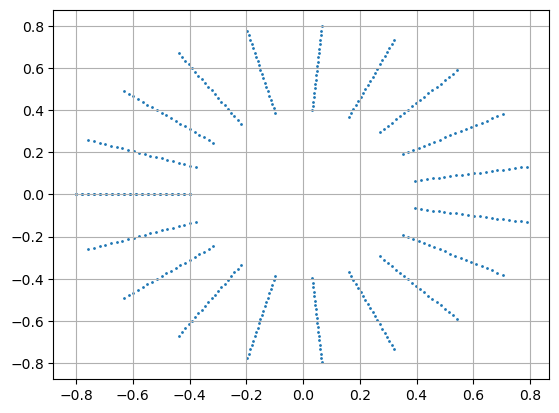

In [4]:
# Plot all inital points in Cartesian coordinate
plt.scatter (X[:,0]*cos(X[:,1]),X[:,0]*sin(X[:,1] ), s=1)
plt.grid()



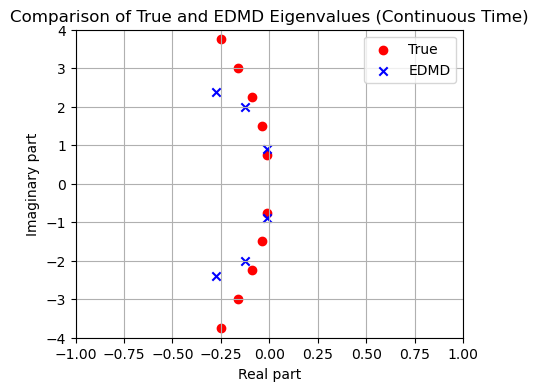

True eigenvalues (continuous time):
[-1.  -7.5j  -0.81-6.75j -0.64-6.j   -0.49-5.25j -0.36-4.5j  -0.25-3.75j
 -0.16-3.j   -0.09-2.25j -0.04-1.5j  -0.01-0.75j -0.01+0.75j -0.04+1.5j
 -0.09+2.25j -0.16+3.j   -0.25+3.75j -0.36+4.5j  -0.49+5.25j -0.64+6.j
 -0.81+6.75j -1.  +7.5j ]

EDMD eigenvalues (continuous time):
[-2.37184785-1.04082105e-13j -1.33038033+7.47178771e-14j
 -0.73378798+1.20833747e+01j -0.73378798-1.20833747e+01j
 -0.59688793-9.00510198e+00j -0.59688793+9.00510198e+00j
 -0.58809289+7.13395479e+00j -0.58809289-7.13395479e+00j
 -0.42563929+5.74151373e+00j -0.42563929-5.74151373e+00j
 -0.27725918-2.38536075e+00j -0.27725918+2.38536075e+00j
 -0.27288032-4.26412009e+00j -0.27288032+4.26412009e+00j
 -0.12447334-1.99679648e+00j -0.12447334+1.99679648e+00j
 -0.01308395+8.99704108e-01j -0.01308395-8.99704108e-01j
  1.15049925+4.22904920e-13j  2.0644258 +4.77258225e-14j]


In [5]:
# Define dictionary
def landau_fourier(X, order=10):
    if X.ndim == 1:
        r, theta = X[0], X[1]
    else:
        r, theta = X[:, 0], X[:, 1]
    basis = []    
    log_term = np.log(2*np.abs(r) + 1e-10)
    for k in range(1, order + 1):
        basis.append(np.exp(1j * k * (theta - log_term)))
        basis.append(np.exp(-1j * k * (theta - log_term)))
    return np.array(basis).T

# def noisy_landau_fourier(X, order=6, noise_std=0.5):
#     basis = landau_fourier(X, order)
#     noise = np.random.normal(0, noise_std, basis.shape) + 1j * np.random.normal(0, noise_std, basis.shape)
#     return basis + noise

# Define EDMD
def edmd(X, Y, dictionary_func, reg=1e-6):
    PsiX = dictionary_func(X)
    PsiY = dictionary_func(Y)
    
    # Add regularization to improve stability
    K = np.linalg.inv(PsiX.T @ PsiX + reg * np.eye(PsiX.shape[1])) @ (PsiX.T @ PsiY)
    
    # Compute eigenvalues and eigenvectors of the Koopman operator
    eigenvalues, eigenvectors = eig(K)
    
    # Compute eigenfunctions
    eigenfunctions = PsiX @ eigenvectors
    
    return K, eigenvalues, eigenvectors, eigenfunctions

# Define true eigenvalues (continuous time)
def true_eigenvalues(delta, gamma, beta, epsilon, n_max=10):
    omega0 = gamma - beta*delta
    eigs = []
    
    # Compute true eigenvalues for the l = 0 case
    for n in range(-n_max, n_max+1):
        if n != 0:  # Skip n = 0 case
            lambda_cont = -n**2 * epsilon**2 * (1 + beta**2) / (2*delta) + 1j*n*omega0
            eigs.append(lambda_cont)
    
    return np.array(eigs)

# Parameters
dt = lag_time  # Assuming lag_time is defined elsewhere

# Perform EDMD
# K, eigenvalues, eigenvectors, eigenfunctions = edmd(X, Y, dictionary_func=noisy_landau_fourier)
K, eigenvalues, eigenvectors, eigenfunctions = edmd(X, Y, dictionary_func=landau_fourier)

# Compute true eigenvalues (continuous time)
true_eigs = true_eigenvalues(delta, gamma, beta, epsilon)

# Convert EDMD eigenvalues to continuous time
# edmd_eigs_cont = np.log(eigenvalues) / dt
edmd_eigs_cont = (eigenvalues - 1) / dt
edmd_eigs_sorted = np.sort_complex(edmd_eigs_cont)

# Plotting for EDMD
plt.figure(figsize=(5, 4))
plt.scatter(true_eigs.real, true_eigs.imag, c='r', label='True', marker='o')
plt.scatter(edmd_eigs_sorted.real, edmd_eigs_sorted.imag, c='b', label='EDMD', marker='x')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Comparison of True and EDMD Eigenvalues (Continuous Time)')
plt.legend()
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-4, 4)
plt.show()

# Print eigenvalues
print("True eigenvalues (continuous time):")
print(true_eigs)
print("\nEDMD eigenvalues (continuous time):")
print(edmd_eigs_sorted)

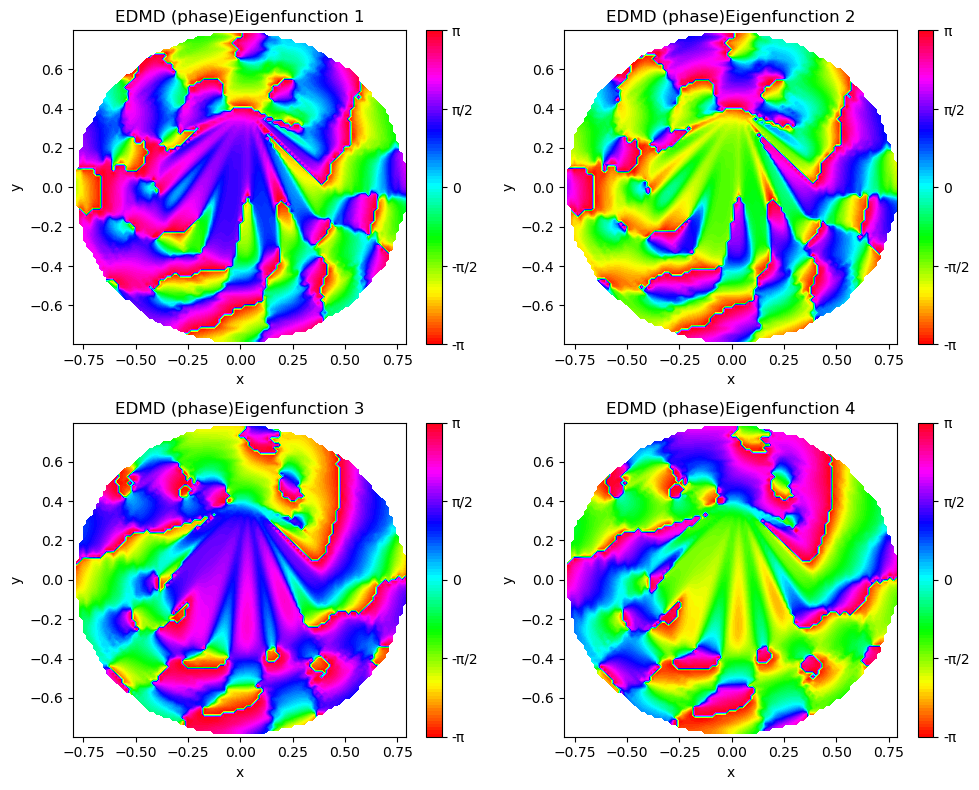

In [6]:
## Plot S-EDMD eigenfunctions without truncation

def plot_eigenfunctions(eigenfunctions, X, n_plot=4):
    r = X[:, 0]
    theta = X[:, 1]
    
    # Convert polar to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Create a grid for plotting
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    
    for i in range(min(n_plot, eigenfunctions.shape[1])):
        # Interpolate the eigenfunction values
        from scipy.interpolate import griddata
        Z_real = griddata((x, y), eigenfunctions[:, i].real, (X, Y), method='cubic')
        Z_imag = griddata((x, y), eigenfunctions[:, i].imag, (X, Y), method='cubic')
        
        # Calculate phase
        Z_phase = np.angle(Z_real + 1j*Z_imag)
        
        # Plot the eigenfunction phase
        im = axes[i].contourf(X, Y, Z_phase, cmap='hsv', levels=np.linspace(-np.pi, np.pi, 100))
        axes[i].set_title(f'EDMD (phase)Eigenfunction {i+1}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        cbar = plt.colorbar(im, ax=axes[i], ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    
    plt.tight_layout()
    plt.show()

# Assume we have already run SEDMD and have eigenfunctions
# If not, you need to run your SEDMD code first

# Then plot the eigenfunctions
plot_eigenfunctions(eigenfunctions, X)

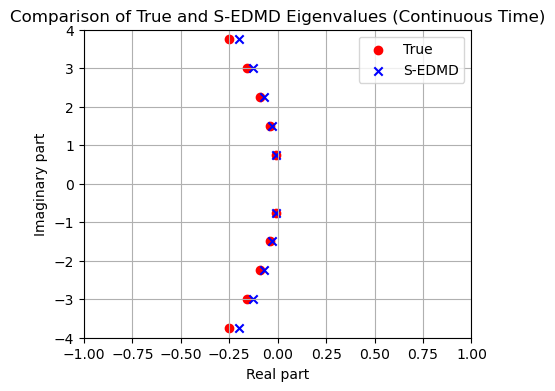

True eigenvalues (continuous time):
[-1.  -7.5j  -0.81-6.75j -0.64-6.j   -0.49-5.25j -0.36-4.5j  -0.25-3.75j
 -0.16-3.j   -0.09-2.25j -0.04-1.5j  -0.01-0.75j -0.01+0.75j -0.04+1.5j
 -0.09+2.25j -0.16+3.j   -0.25+3.75j -0.36+4.5j  -0.49+5.25j -0.64+6.j
 -0.81+6.75j -1.  +7.5j ]

S-EDMD eigenvalues (continuous time):
[-0.79325259+7.49468907j -0.79325259-7.49468907j -0.64321457-6.74743358j
 -0.64321457+6.74743358j -0.50664564-6.00268492j -0.50664564+6.00268492j
 -0.38809256+5.25044758j -0.38809256-5.25044758j -0.28519148-4.50011276j
 -0.28519148+4.50011276j -0.19806855-3.74940335j -0.19806855+3.74940335j
 -0.1263829 -3.00112252j -0.1263829 +3.00112252j -0.07112195-2.24999286j
 -0.07112195+2.24999286j -0.03155886-1.50061114j -0.03155886+1.50061114j
 -0.00767628-0.7500188j  -0.00767628+0.7500188j ]


In [7]:
def jacobian(basis_func, X):
    h = 1e-8
    n_samples, n_dims = X.shape
    n_basis = basis_func(X).shape[1]
    jac = np.zeros((n_samples, n_dims, n_basis), dtype=complex)
    
    for i in range(n_dims):
        X_plus = X.copy()
        X_plus[:, i] += h
        curr_jac = (basis_func(X_plus) - basis_func(X)) / h
        jac[:, i, :] = curr_jac
    
    return jac

def hessian(basis_func, X):
    h = 1e-8
    n_samples, n_dims = X.shape
    n_basis = basis_func(X).shape[1]
    hess = np.zeros((n_samples, n_dims, n_dims, n_basis), dtype=complex)
    
    for i in range(n_dims):
        for j in range(n_dims):
            X_plus_i = X.copy()
            X_plus_i[:, i] += h
            X_plus_j = X.copy()
            X_plus_j[:, j] += h
            X_plus_ij = X.copy()
            X_plus_ij[:, i] += h
            X_plus_ij[:, j] += h
            
            curr_hess = (basis_func(X_plus_ij) - basis_func(X_plus_i) - basis_func(X_plus_j) + basis_func(X)) / (h * h)
            hess[:, i, j, :] = curr_hess
    
    return hess

def sl_drift(x, delta, gamma, beta, epsilon):
    r, theta = x
    r_drift = delta * r - r**3 + epsilon**2 / (2 * r)
    theta_drift = gamma - beta * r**2
    return np.array([r_drift, theta_drift])

def sl_diffusion(x, epsilon):
    r, _ = x
    return np.array([[epsilon, 0], [0, epsilon / r]])

def sedmd(X, dictionary_func, drift, diffusion, dt, delta, gamma, beta, epsilon, reg=1e-6):
    PsiX = dictionary_func(X)
    
    jac_PsiX = jacobian(dictionary_func, X)
    hess_PsiX = hessian(dictionary_func, X)
    
    n_samples, n_dims = X.shape
    n_basis = PsiX.shape[1]
    L_PsiX = np.zeros_like(PsiX, dtype=complex)
    
    for i in range(n_samples):
        b = drift(X[i], delta, gamma, beta, epsilon)
        sigma = diffusion(X[i], epsilon)
        sigma_squared = sigma @ sigma.T
        
        L_PsiX[i] = np.sum(b[:, np.newaxis] * jac_PsiX[i], axis=0) + 0.5 * np.sum(np.sum(sigma_squared[:, :, np.newaxis] * hess_PsiX[i], axis=1), axis=0)
    
    K = np.linalg.inv(PsiX.T.conj() @ PsiX + reg * np.eye(PsiX.shape[1])) @ (PsiX.T.conj() @ (PsiX + dt * L_PsiX))
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(K)
    eigenfunctions = PsiX @ eigenvectors
    
    return K, eigenvalues, eigenvectors, eigenfunctions

# Perform SEDMD
K, eigenvalues, eigenvectors, eigenfunctions = sedmd(
    X, 
    dictionary_func=landau_fourier, 
    drift=sl_drift, 
    diffusion=sl_diffusion,
    dt=dt,
    delta=delta,
    gamma=gamma,
    beta=beta,
    epsilon=epsilon
)

# Convert S-EDMD eigenvalues to continuous time
# sedmd_eigs_cont = np.log(eigenvalues) / dt
sedmd_eigs_cont = (eigenvalues - 1) / dt
sedmd_eigs_sorted = np.sort_complex(sedmd_eigs_cont)

# Plotting for S-EDMD
plt.figure(figsize=(5, 4))
plt.scatter(true_eigs.real, true_eigs.imag, c='r', label='True', marker='o')
plt.scatter(sedmd_eigs_sorted.real, sedmd_eigs_sorted.imag, c='b', label='S-EDMD', marker='x')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Comparison of True and S-EDMD Eigenvalues (Continuous Time)')
plt.legend()
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-4, 4)
plt.show()

# Print eigenvalues
print("True eigenvalues (continuous time):")
print(true_eigs)
print("\nS-EDMD eigenvalues (continuous time):")
print(sedmd_eigs_sorted)


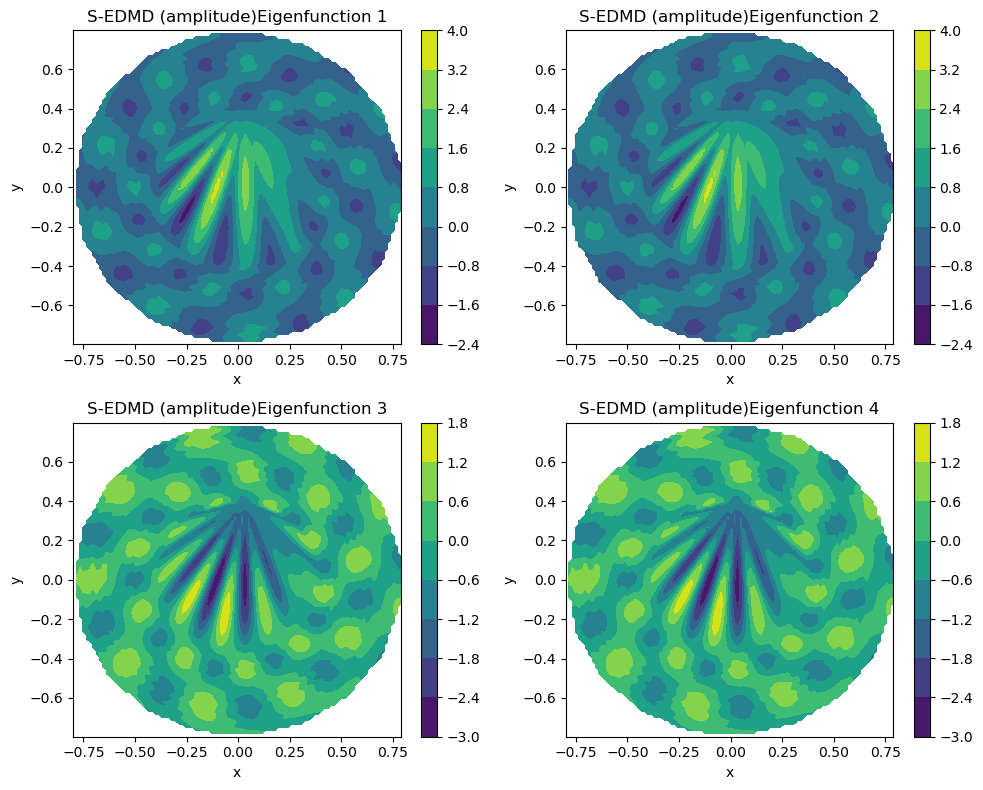

In [8]:
## Plot S-EDMD eigenfunctions(amplitude)

def plot_eigenfunctions(eigenfunctions, X, n_plot=4):
    r = X[:, 0]
    theta = X[:, 1]
    
    # Convert polar to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Create a grid for plotting
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    
    for i in range(min(n_plot, eigenfunctions.shape[1])):
        # Interpolate the eigenfunction values
        from scipy.interpolate import griddata
        Z = griddata((x, y), eigenfunctions[:, i].real, (X, Y), method='cubic')
        
        # Plot the eigenfunction
        im = axes[i].contourf(X, Y, Z, cmap='viridis')
        axes[i].set_title(f'S-EDMD (amplitude)Eigenfunction {i+1}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()

# Assume we have already run SEDMD and have eigenfunctions
# If not, you need to run your SEDMD code first

# Then plot the eigenfunctions
plot_eigenfunctions(eigenfunctions, X)

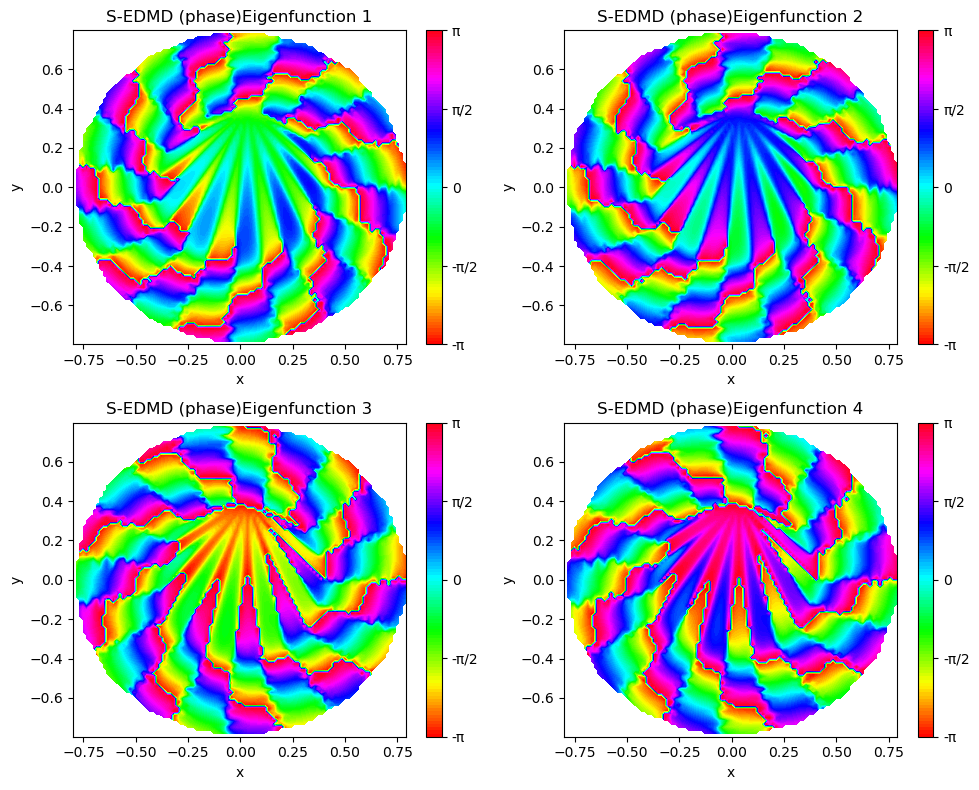

In [9]:
## Plot S-EDMD eigenfunctions without truncation

def plot_eigenfunctions(eigenfunctions, X, n_plot=4):
    r = X[:, 0]
    theta = X[:, 1]
    
    # Convert polar to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Create a grid for plotting
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    
    for i in range(min(n_plot, eigenfunctions.shape[1])):
        # Interpolate the eigenfunction values
        from scipy.interpolate import griddata
        Z_real = griddata((x, y), eigenfunctions[:, i].real, (X, Y), method='cubic')
        Z_imag = griddata((x, y), eigenfunctions[:, i].imag, (X, Y), method='cubic')
        
        # Calculate phase
        Z_phase = np.angle(Z_real + 1j*Z_imag)
        
        # Plot the eigenfunction phase
        im = axes[i].contourf(X, Y, Z_phase, cmap='hsv', levels=np.linspace(-np.pi, np.pi, 100))
        axes[i].set_title(f'S-EDMD (phase)Eigenfunction {i+1}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        cbar = plt.colorbar(im, ax=axes[i], ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    
    plt.tight_layout()
    plt.show()

# Assume we have already run SEDMD and have eigenfunctions
# If not, you need to run your SEDMD code first

# Then plot the eigenfunctions
plot_eigenfunctions(eigenfunctions, X)

C:\Users\xyc93\AppData\Local\Temp\ipykernel_28376\1675693416.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return (2**k * np.math.factorial(k))**(-0.5) * np.exp(1j*n*(theta - beta_bar*np.log(r/R))) * H(np.sqrt(2*delta)/epsilon * (r - R))
C:\Users\xyc93\AppData\Local\Temp\ipykernel_28376\1675693416.py:6: RuntimeWarning: divide by zero encountered in log
  return (2**k * np.math.factorial(k))**(-0.5) * np.exp(1j*n*(theta - beta_bar*np.log(r/R))) * H(np.sqrt(2*delta)/epsilon * (r - R))
C:\Users\xyc93\AppData\Local\Temp\ipykernel_28376\1675693416.py:6: RuntimeWarning: invalid value encountered in multiply
  return (2**k * np.math.factorial(k))**(-0.5) * np.exp(1j*n*(theta - beta_bar*np.log(r/R))) * H(np.sqrt(2*delta)/epsilon * (r - R))


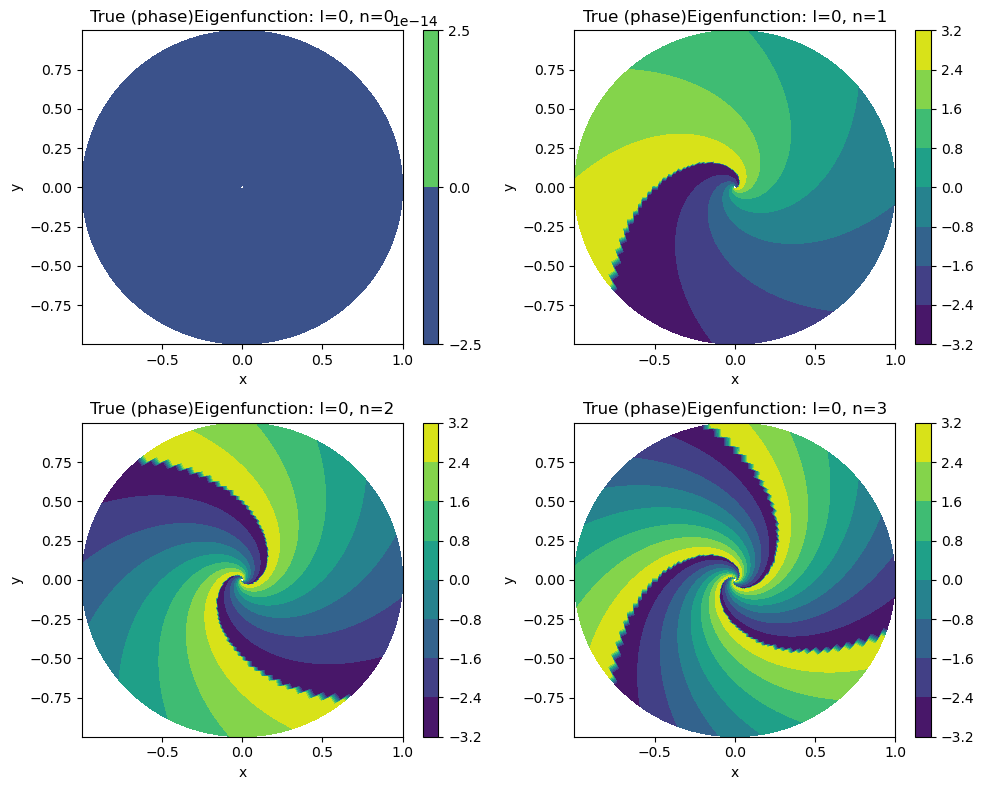

In [10]:
## Plot analytical eigenfunctions(angle/phase)

def analytical_eigenfunction(r, theta, n, l, R, delta, epsilon, beta_bar):
    k = abs(n)
    H = hermite(l)
    return (2**k * np.math.factorial(k))**(-0.5) * np.exp(1j*n*(theta - beta_bar*np.log(r/R))) * H(np.sqrt(2*delta)/epsilon * (r - R))

# Set parameters
R = np.sqrt(delta)  # Radius of the limit cycle
delta = delta
epsilon = epsilon
beta_bar = 1.0

# Create grid
r = np.linspace(0.0, 1.0, 100)
theta = np.linspace(0, 2*np.pi, 100)
r_grid, theta_grid = np.meshgrid(r, theta)

# Convert to Cartesian coordinates
x = r_grid * np.cos(theta_grid)
y = r_grid * np.sin(theta_grid)

# Plot the first 4 eigenfunctions (l=0, n=0,1,2,3)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, n in enumerate([0, 1, 2, 3]):
    psi = analytical_eigenfunction(r_grid, theta_grid, n, 0, R, delta, epsilon, beta_bar)
    im = axs[i].contourf(x, y, np.angle(psi), cmap='viridis') # angle for phase, abs for amplitude
    axs[i].set_title(f'True (phase)Eigenfunction: l=0, n={n}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    plt.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()